# Alignments
* FFHQ recreate_aligned_images 演算法
    * 利用眼睛, 嘴巴 landmarks 找到中心點 c, 與x, y 向量
    * 由於 x, y 長度相同，所以形成的四邊形其實為矩形([c - x - y, c - x + y, c + x - y, c + x + y])
    * 但對於 deepfashion 模特兒的頭大多都在靠近照片上方邊緣處，造成 (x1, y1) 被迫下移形成四邊形
    * padding 後使得 align 過後的臉上方有 reflect padding 痕跡，老師也認為 align 的臉好像沒有完美對齊

In [1]:
import os
import random
from pathlib import Path
import cv2
import numpy as np
from PIL import Image, ImageDraw
from matplotlib import cm
from tqdm import tqdm
from IPython.display import display

In [78]:
import PIL.Image
import PIL.ImageFile
import numpy as np
import scipy.ndimage
import pandas as pd

import matplotlib.pyplot as plt

In [3]:
import json
landmarks = json.load(open('deepfashion_landmarks.json', 'r'))

### Mind
* 矩形是由左右眼 + 嘴巴中間而來
* 統計後在 2D 上得到接近橢圓的分佈 -> 當作是 Gaussian

In [122]:
def get_cxy(lm):
    lm = np.array(lm)
    lm_chin          = lm[0  : 17]  # left-right
    lm_eyebrow_left  = lm[17 : 22]  # left-right
    lm_eyebrow_right = lm[22 : 27]  # left-right
    lm_nose          = lm[27 : 31]  # top-down
    lm_nostrils      = lm[31 : 36]  # top-down
    lm_eye_left      = lm[36 : 42]  # left-clockwise
    lm_eye_right     = lm[42 : 48]  # left-clockwise
    lm_mouth_outer   = lm[48 : 60]  # left-clockwise
    lm_mouth_inner   = lm[60 : 68]  # left-clockwise

    # Calculate auxiliary vectors.
    eye_left     = np.mean(lm_eye_left, axis=0)
    eye_right    = np.mean(lm_eye_right, axis=0)
    eye_avg      = (eye_left + eye_right) * 0.5
    eye_to_eye   = eye_right - eye_left
    mouth_left   = lm_mouth_outer[0]
    mouth_right  = lm_mouth_outer[6]
    mouth_avg    = (mouth_left + mouth_right) * 0.5
    eye_to_mouth = mouth_avg - eye_avg

    # Choose oriented crop rectangle.
    x = eye_to_eye - np.flipud(eye_to_mouth) * [-1, 1]
    x /= np.hypot(*x)
    x *= max(np.hypot(*eye_to_eye) * 2.0, np.hypot(*eye_to_mouth) * 1.8)
    y = np.flipud(x) * [-1, 1]
    c = eye_avg + eye_to_mouth * 0.1
    quad = np.stack([c - x - y, c - x + y, c + x + y, c + x - y])
    
    return c, x, np.hypot(*eye_to_eye) * 2.0 > np.hypot(*eye_to_mouth) * 1.8

In [6]:
cs, xs, eye2eye = [], [], []
for item in landmarks.values():
    c, x, t = get_cxy(item['in_the_wild']['face_landmarks'])
    cs.append(c)
    xs.append(x)
    eye2eye.append(t)
    
cs = np.array(cs)
xs = np.array(xs)
eye2eye = np.array(eye2eye)

In [32]:
x_norm = np.linalg.norm(xs, axis=1)

In [66]:
def cart2pol(p):
    x, y = p
    rho = np.sqrt(x**2 + y**2)
    phi = (np.arctan2(y, x)) % (2 * np.pi)
    return(rho, phi)

### X NORM
* 有兩個分佈，但不大像 Gaussian
* 與取 eye2eye 或是 eye2mouth 無關（橘色與綠色也各都分成兩部分）
* eye2mouth 數量與平均都比 eye2eye 小

eye2eye: 19611, eye2mouth: 8289


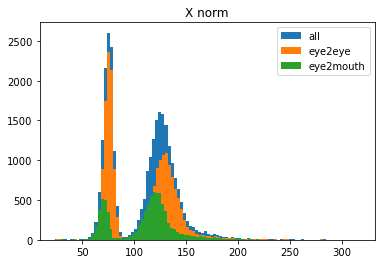

In [112]:
print(f'eye2eye: {eye2eye.sum()}, eye2mouth: {(~eye2eye).sum()}')
num_bins = 100
plt.figure()
plt.title('X norm')
plt.hist(x_norm, bins=num_bins, label='all')
plt.hist(x_norm[eye2eye], bins=num_bins, label='eye2eye')
plt.hist(x_norm[~eye2eye], bins=num_bins, label='eye2mouth')
plt.legend()
plt.show()

### X norm 與 C 的關係

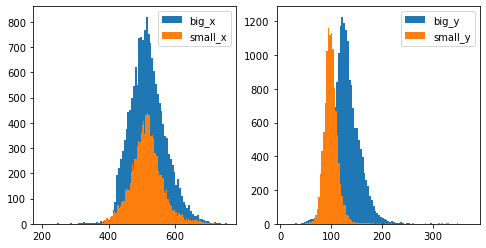

In [111]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].hist(cs[x_norm >= 90, 0], bins=100, label='big_x')
ax[0].hist(cs[x_norm < 90, 0], bins=100, label='small_x')
ax[0].legend()

ax[1].hist(cs[x_norm >= 90, 1], bins=100, label='big_y')
ax[1].hist(cs[x_norm < 90, 1], bins=100, label='small_y')
ax[1].legend()

plt.show()

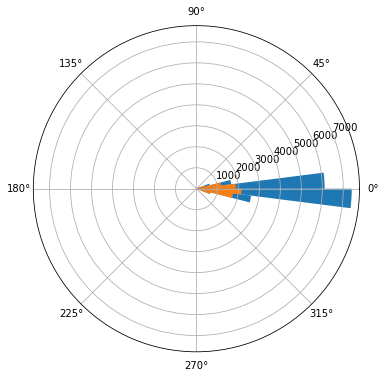

In [108]:
N = 50
width = (2*np.pi) / N
plt.subplots(figsize=(6,6))
ax = plt.subplot(111, polar=True)

X = xs[eye2eye]
phi = np.arctan2(X[:, 1], X[:, 0]) % (2 * np.pi)
radii, bins = np.histogram(phi, bins=N)
bars = (bins[1:] + bins[:-1]) / 2
_ = ax.bar(bars, radii, width=width, bottom=0, label='eye2eye')

X = xs[~eye2eye]
phi = np.arctan2(X[:, 1], X[:, 0]) % (2 * np.pi)
radii, bins = np.histogram(phi, bins=N)
bars = (bins[1:] + bins[:-1]) / 2
_ = ax.bar(bars, radii, width=width, bottom=0, label='eye2mouth')


# Use custom colors and opacity
# for r, bar in zip(radii, bars):
#     bar.set_facecolor(plt.cm.jet(r / 10.))
#     bar.set_alpha(0.8)

In [121]:
X = xs#[eye2eye]
angle = np.arctan2(X[:, 1], X[:, 0]) % (2 * np.pi)
X_norm = np.linalg.norm(X, axis=1)
np.corrcoef(np.vstack([X_norm, angle]))

array([[ 1.        , -0.00541111],
       [-0.00541111,  1.        ]])

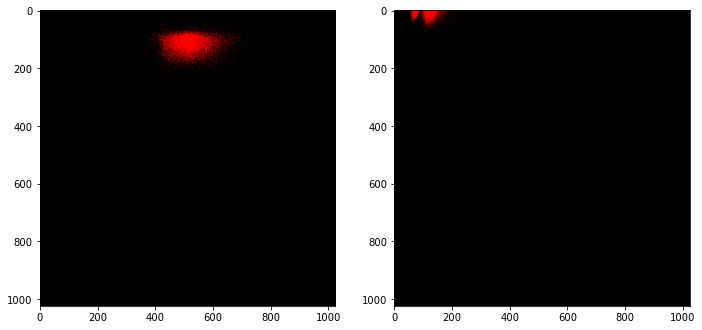

In [8]:
# imgs = []
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
for i, points in enumerate(point_list, 1):
    img = Image.new('RGB', (1024, 1024))
    imgd = ImageDraw.ImageDraw(img)
    imgd.point(points, fill="red")
    ax = plt.subplot(1,3,i)
    ax.imshow(np.array(img))
    # imgs.append(np.array(img))

plt.show()
# display(Image.fromarray(np.hstack(imgs)))


In [45]:
from scipy.stats import multivariate_normal
eye_left = np.array(point_list[0])
mu = eye_left.mean(axis=0)
Sigma = np.cov(eye_left, rowvar=False)
F = multivariate_normal(mu, Sigma)

X = np.linspace(mu[0] - 130, mu[0] + 130, 100)
Y = np.linspace(mu[1] - 70, mu[1] + 70, 60)
X, Y = np.meshgrid(X, Y)
pos = np.empty(X.shape + (2,))
pos[..., 0] = X
pos[..., 1] = Y

Z = F.pdf(pos)

In [47]:
assert X.shape == Y.shape == Z.shape
print(X.shape)
print(mu)
print(Sigma)

(60, 100)
[491.12150538 113.76153524]
[[2727.26779881 -170.7131207 ]
 [-170.7131207   706.38408919]]


In [44]:
from scipy.stats import norm
mu, std = norm.fit(eye_left)
mu, std

(302.44152031063317, 193.1758296822236)

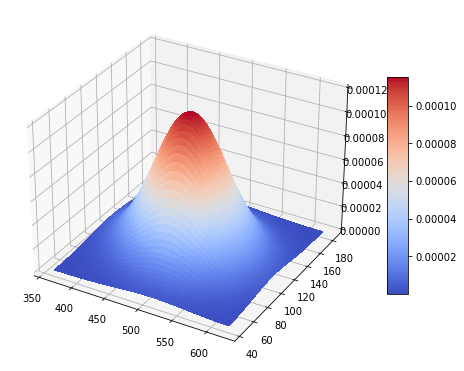

In [39]:
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')

surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_zlim(0, 0.00012)
fig.colorbar(surf, shrink=0.5, aspect=10)

518.5 91.0


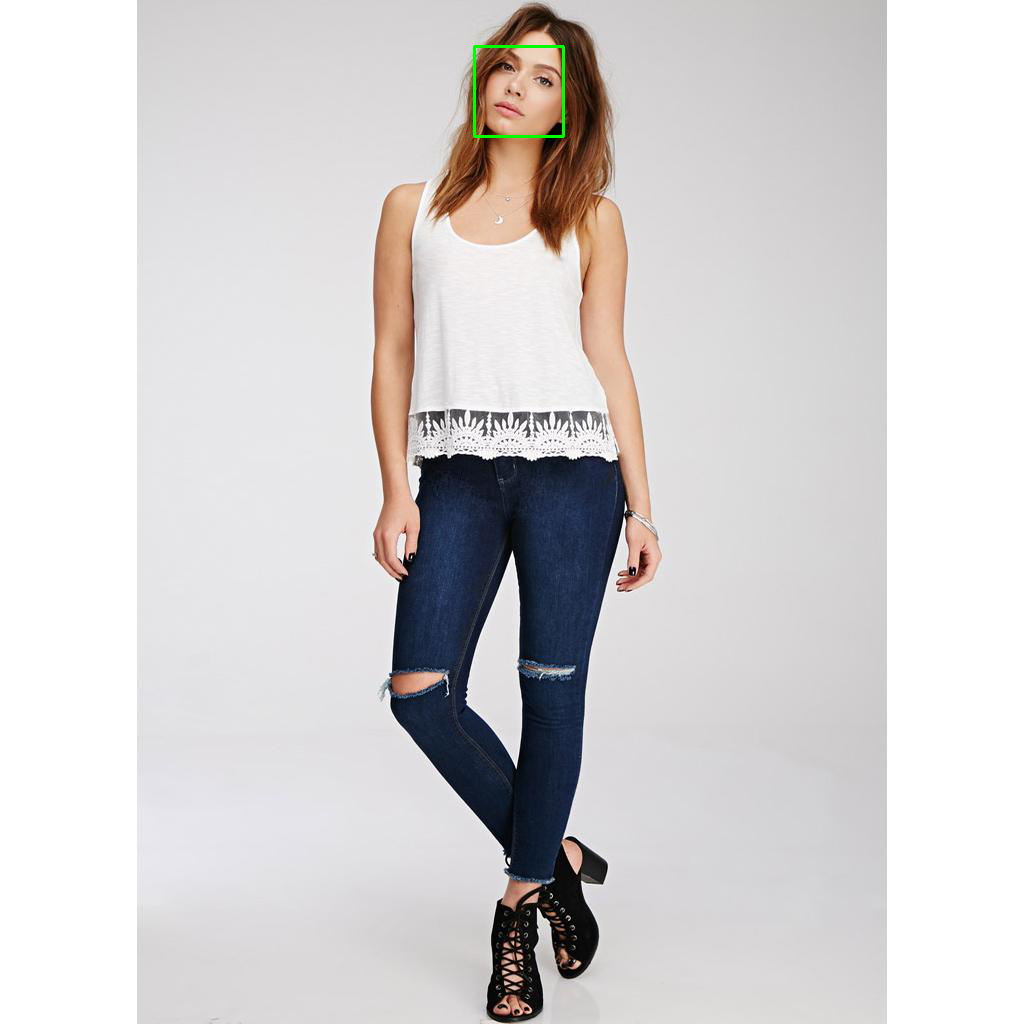

In [7]:
img = Image.open(landmarks['1']['in_the_wild']['file_path'])
img_np = np.array(img)
(x, y, w, h) = landmarks['1']['in_the_wild']['box']
print(x + w * 1/2, y + h * 1/2)
cv2.rectangle(img_np, (x, y), (x + w, y + h), (0, 255, 0), 2)
# display(Image.fromarray(img_np))

## Step by Step (to understanding alignment algorithm)

In [72]:
OUTPUT_SIZE = 256
ENABLE_PADDING = True
FIG = landmarks['6']['in_the_wild']

def draw_point(imgd, point, r=3, color="#ff0000"):
    point = point.astype(int)
    imgd.ellipse([*(point - r), *(point + r)], fill=color)
    
def draw_quad(imgd, quad, color="#ff0000"):
    display_quad = np.where(quad < 0, 0, quad).astype(int)
    print(display_quad)
    for idx in reversed(range(display_quad.shape[0])):
        imgd.line([*display_quad[idx], *display_quad[idx - 1]], fill=color)

img = Image.open(FIG['file_path'])
imgd = ImageDraw.ImageDraw(img)

In [73]:
lm = np.array(FIG['face_landmarks'])
lm_chin          = lm[0  : 17]  # left-right
lm_eyebrow_left  = lm[17 : 22]  # left-right
lm_eyebrow_right = lm[22 : 27]  # left-right
lm_nose          = lm[27 : 31]  # top-down
lm_nostrils      = lm[31 : 36]  # top-down
lm_eye_left      = lm[36 : 42]  # left-clockwise
lm_eye_right     = lm[42 : 48]  # left-clockwise
lm_mouth_outer   = lm[48 : 60]  # left-clockwise
lm_mouth_inner   = lm[60 : 68]  # left-clockwise

# Calculate auxiliary vectors.
eye_left     = np.mean(lm_eye_left, axis=0)
eye_right    = np.mean(lm_eye_right, axis=0)
eye_avg      = (eye_left + eye_right) * 0.5
eye_to_eye   = eye_right - eye_left
mouth_left   = lm_mouth_outer[0]
mouth_right  = lm_mouth_outer[6]
mouth_avg    = (mouth_left + mouth_right) * 0.5
eye_to_mouth = mouth_avg - eye_avg

# Choose oriented crop rectangle.
print(f"eye to eye: {eye_to_eye}, eye to mouth: {eye_to_mouth}")
x = eye_to_eye - np.flipud(eye_to_mouth) * [-1, 1]
_x = x.copy()
print(f"x: {x}", end=" -> ")
x /= np.hypot(*x)
print(x, end=" -> ")
x *= max(np.hypot(*eye_to_eye) * 2.0, np.hypot(*eye_to_mouth) * 1.8)
print(x)
y = np.flipud(x) * [-1, 1]
c = eye_avg + eye_to_mouth * 0.1
quad = np.stack([c - x - y, c - x + y, c + x + y, c + x - y])
qsize = np.hypot(*x) * 2

print("y: ", y)
print("quad shape: ", quad.shape)
print(quad)

eye to eye: [58.5        20.16666667], eye to mouth: [-22.41666667  73.41666667]
x: [131.91666667  42.58333333] -> [0.95164627 0.30719599] -> [131.49170691  42.44615428]
y:  [-42.44615428 131.49170691]
quad shape:  (4, 2)
[[445.12944737 -92.0128612 ]
 [360.2371388  170.97055263]
 [623.22055263 255.8628612 ]
 [708.1128612   -7.12055263]]


In [58]:
# Shrink.
shrink = int(np.floor(qsize / OUTPUT_SIZE * 0.5))
print("shrink: ", shrink)
if shrink > 1:
    rsize = (int(np.rint(float(img.size[0]) / shrink)), int(np.rint(float(img.size[1]) / shrink)))
    img = img.resize(rsize, PIL.Image.ANTIALIAS)
    quad /= shrink
    qsize /= shrink
    
    draw_quad(imgd, quad, color="#ff0000")
    display(img)   

shrink:  0


(408, 0, 638, 193)


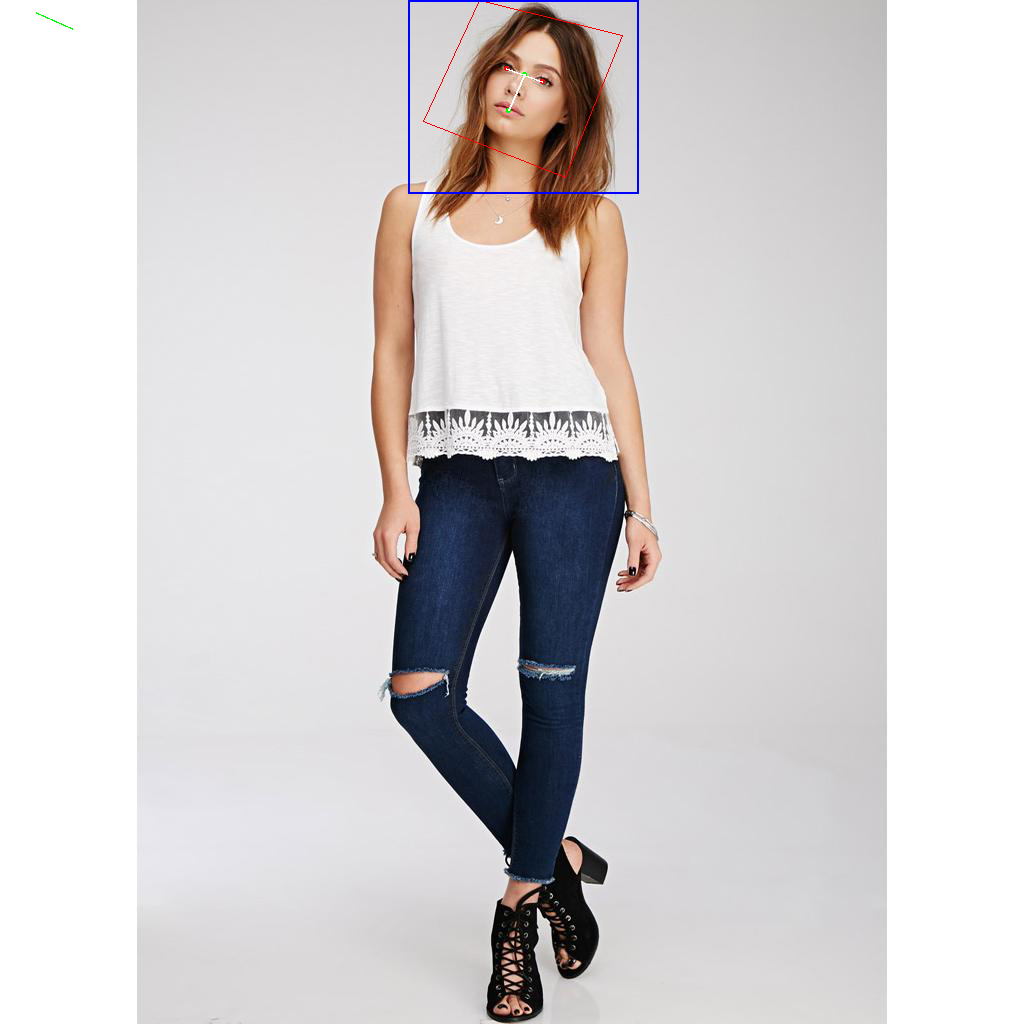

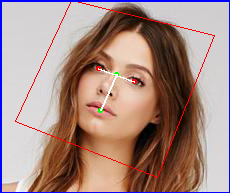

In [84]:
# Crop.
border = max(int(np.rint(qsize * 0.1)), 3)
crop = (int(np.floor(min(quad[:,0]))), int(np.floor(min(quad[:,1]))), int(np.ceil(max(quad[:,0]))), int(np.ceil(max(quad[:,1]))))
crop = (max(crop[0] - border, 0), max(crop[1] - border, 0), min(crop[2] + border, img.size[0]), min(crop[3] + border, img.size[1]))

print(crop)
imgd.rectangle(crop, width=2, outline="#0000ff")
display(img)

if crop[2] - crop[0] < img.size[0] or crop[3] - crop[1] < img.size[1]:
    img = img.crop(crop)
    quad -= crop[0:2]
    
display(img)

pad:  (0, 37, 0, 0)
image size:  (322, 285)
[[117  24]
 [ 61 167]
 [203 223]
 [260  81]]


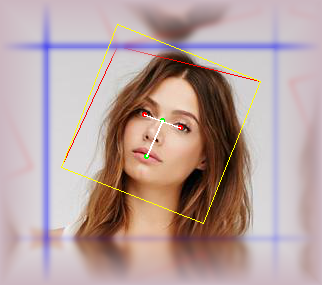

In [85]:
# padding
pad = (int(np.floor(min(quad[:,0]))), int(np.floor(min(quad[:,1]))), int(np.ceil(max(quad[:,0]))), int(np.ceil(max(quad[:,1]))))
pad = (max(-pad[0] + border, 0), max(-pad[1] + border, 0), max(pad[2] - img.size[0] + border, 0), max(pad[3] - img.size[1] + border, 0))
print("pad: ", pad)
if ENABLE_PADDING and max(pad) > border - 4:
    pad = np.maximum(pad, int(np.rint(qsize * 0.3)))
    img = np.pad(np.float32(img), ((pad[1], pad[3]), (pad[0], pad[2]), (0, 0)), 'reflect')
    h, w, _ = img.shape
    y, x, _ = np.ogrid[:h, :w, :1]
    mask = np.maximum(1.0 - np.minimum(np.float32(x) / pad[0], np.float32(w-1-x) / pad[2]), 1.0 - np.minimum(np.float32(y) / pad[1], np.float32(h-1-y) / pad[3]))
    blur = qsize * 0.02
    img += (scipy.ndimage.gaussian_filter(img, [blur, blur, 0]) - img) * np.clip(mask * 3.0 + 1.0, 0.0, 1.0)
    img += (np.median(img, axis=(0,1)) - img) * np.clip(mask, 0.0, 1.0)
    img = PIL.Image.fromarray(np.uint8(np.clip(np.rint(img), 0, 255)), 'RGB')
    quad += pad[:2]
    
    print("image size: ", img.size)
    imgd = ImageDraw.ImageDraw(img)
    draw_quad(imgd, quad, color="#ffff00")
    display(img)    

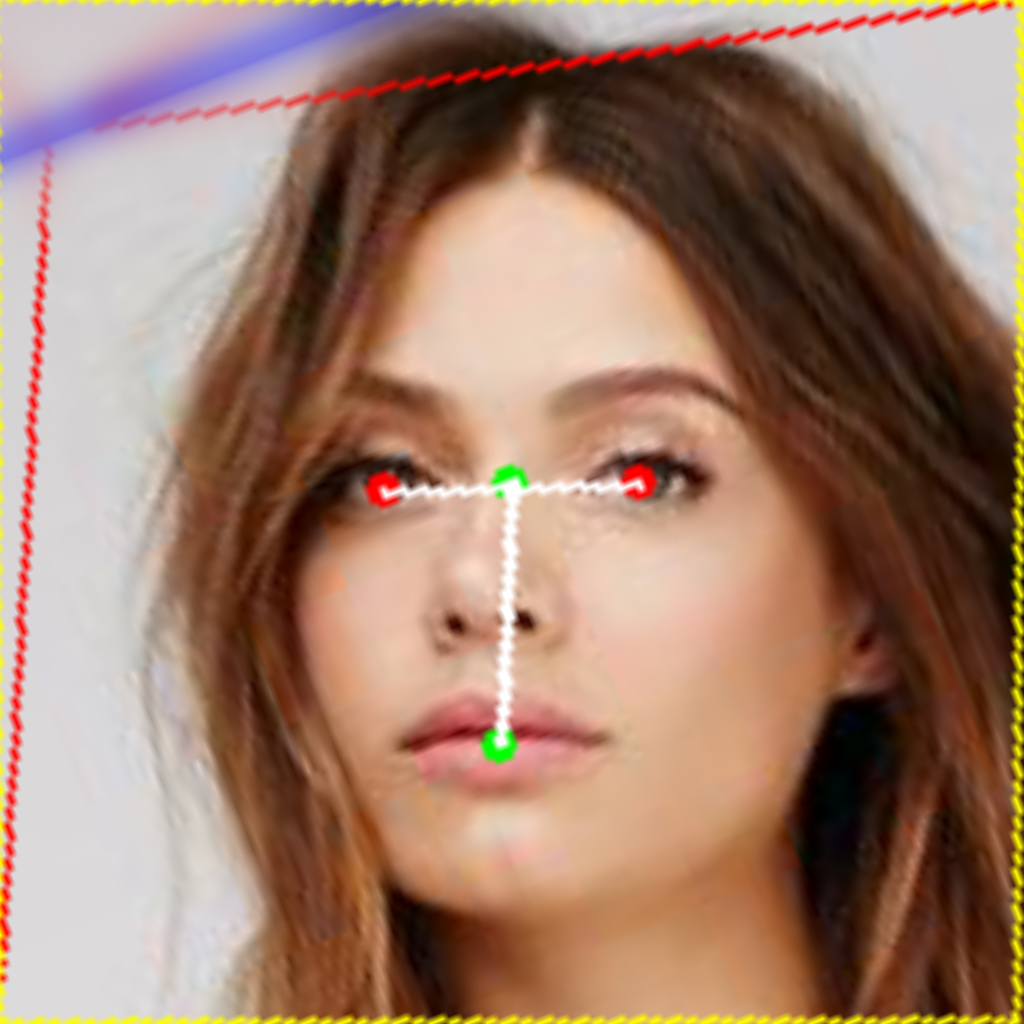

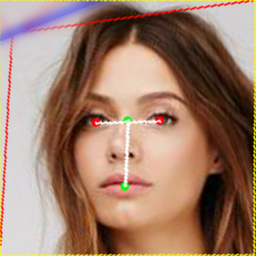

In [86]:
# Transform.
img = img.transform((OUTPUT_SIZE * 4, OUTPUT_SIZE * 4), PIL.Image.QUAD, (quad + 0.5).flatten(), PIL.Image.BILINEAR)
display(img)
img = img.resize((OUTPUT_SIZE, OUTPUT_SIZE), PIL.Image.ANTIALIAS)
display(img)